In [67]:
import pandas as pd
import datasets

from pprint import pprint
from transformers import AutoTokenizer

In [68]:
from transformers import AutoModelForSeq2SeqLM


MODEL_NAME = "google/flan-t5-small"
FINETUNED_MODEL_DIR = "./ghana-finetuned-model"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
list_texts = "Hi, how are you?"


In [69]:
text = "Hi, how are you?"
encoded_text = tokenizer(text)["input_ids"]
print("Encoded several texts: ", encoded_text)
decoded_text = tokenizer.decode(encoded_text)
print("Decoded tokens back into text: ", decoded_text)

Encoded several texts:  [2018, 6, 149, 33, 25, 58, 1]
Decoded tokens back into text:  Hi, how are you?</s>


In [80]:
list_texts = ["Hi, how are you?", "I'm good", "Yes"]
tokenizer.pad_token = tokenizer.eos_token 
encoded_texts_longest = tokenizer(list_texts, padding=True)
print("Using padding: ", encoded_texts_longest["input_ids"])

Using padding:  [[2018, 6, 149, 33, 25, 58, 1], [27, 31, 51, 207, 1, 1, 1], [2163, 1, 1, 1, 1, 1, 1]]


In [82]:
encoded_texts_truncation = tokenizer(list_texts, max_length=5, truncation=True)
print("Using truncation: ", encoded_texts_truncation["input_ids"])

Using truncation:  [[2018, 6, 149, 33, 1], [27, 31, 51, 207, 1], [2163, 1]]


In [83]:
tokenizer.truncation_side = "left"
encoded_texts_truncation_left = tokenizer(list_texts, max_length=3, truncation=True)
print("Using left-side truncation: ", encoded_texts_truncation_left["input_ids"])

Using left-side truncation:  [[25, 58, 1], [51, 207, 1], [2163, 1]]


In [84]:
encoded_texts_both = tokenizer(list_texts, max_length=3, truncation=True, padding=True)
print("Using both padding and truncation: ", encoded_texts_both["input_ids"])

Using both padding and truncation:  [[25, 58, 1], [51, 207, 1], [2163, 1, 1]]


In [85]:
def tokenize_function(examples):
    # When batched=True, examples contains lists of questions and answers
    if "question" in examples and "answer" in examples:
        # Combine each question with its answer
        texts = [q + " " + a for q, a in zip(examples["question"], examples["answer"])]
    elif "input" in examples and "output" in examples:
        texts = [i + " " + o for i, o in zip(examples["input"], examples["output"])]
    else:
        texts = examples["text"]

    tokenizer.pad_token = tokenizer.eos_token
    
    # Tokenize all texts
    tokenized_inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=512,  # Set a reasonable max length
        return_tensors=None  # Return lists, not tensors for dataset.map
    )

    return tokenized_inputs

print("Tokenizing dataset...")
# Use 'json' for JSONL files, not 'csv'
dataset = datasets.load_dataset("json", data_files="test/ghana_qa.json")
tokenized_dataset = dataset.map(tokenize_function, batched=True)
print("Tokenized dataset sample:")
print(f"Number of examples: {len(tokenized_dataset['train'])}")
print(f"\nFirst example:")
pprint(tokenized_dataset["train"][0])

Tokenizing dataset...
Tokenized dataset sample:
Number of examples: 111

First example:
{'answer': 'March 6, 1957',
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'input_ids': [366,
               410,
               18406,
               2485,
               12315,
               58,
               1332,
               8580,
               24011,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1,
               1],
 'question': 'When did Ghana gain independence?'}


# Prepare Model for Fine-Tuning
Now we'll load the model and configure it for fine-tuning with LoRA (Low-Rank Adaptation)

In [86]:
from transformers import AutoModelForSeq2SeqLM, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
import numpy as np

# Load the base model
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

# Configure LoRA
lora_config = LoraConfig(
    r=16,  # Rank of the low-rank matrices
    lora_alpha=32,  # Scaling factor
    target_modules=["q", "v", "k", "o"],  # Which layers to apply LoRA to
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM
)

# Apply LoRA to the model
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()
print("\nModel prepared for fine-tuning!")

trainable params: 1,376,256 || all params: 78,337,408 || trainable%: 1.7568

Model prepared for fine-tuning!


# Prepare Training Data
We need to preprocess the dataset properly for Seq2Seq training with input_ids and labels

In [87]:
def preprocess_function(examples):
    """Preprocess data for Seq2Seq training"""
    # Tokenize inputs (questions)
    model_inputs = tokenizer(
        examples["question"],
        max_length=128,
        truncation=True,
        padding="max_length"
    )
    
    # Tokenize targets (answers)
    labels = tokenizer(
        examples["answer"],
        max_length=128,
        truncation=True,
        padding="max_length"
    )
    
    # Replace padding token id with -100 so it's ignored in loss calculation
    labels["input_ids"] = [
        [(label if label != tokenizer.pad_token_id else -100) for label in labels_example]
        for labels_example in labels["input_ids"]
    ]
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply preprocessing
print("Preprocessing dataset for training...")
processed_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset["train"].column_names)
print(f"Processed dataset: {processed_dataset}")
print(f"\nSample preprocessed data:")
print(f"Input IDs length: {len(processed_dataset['train'][0]['input_ids'])}")
print(f"Labels length: {len(processed_dataset['train'][0]['labels'])}")

Preprocessing dataset for training...
Processed dataset: DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 111
    })
})

Sample preprocessed data:
Input IDs length: 128
Labels length: 128


# Train the Model
Configure training arguments and start fine-tuning

In [88]:
import os
from transformers import TrainerCallback

# Custom callback to track training metrics
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.training_loss = []
        self.steps = []
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'loss' in logs:
            self.training_loss.append(logs['loss'])
            self.steps.append(state.global_step)

# Create output directory
output_dir = "./ghana-finetuned-model"
os.makedirs(output_dir, exist_ok=True)

# Training arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=5,
    per_device_train_batch_size=4,
    learning_rate=1e-3,
    logging_steps=10,
    save_strategy="epoch",
    report_to="none",  # Disable wandb/tensorboard
    remove_unused_columns=False,
)

# Create metrics callback
metrics_callback = MetricsCallback()

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    tokenizer=tokenizer,
    callbacks=[metrics_callback],
)

print("Starting training...")
print("=" * 50)
trainer.train()
print("=" * 50)
print("Training complete!")

# Store metrics for plotting
training_history = {
    'steps': metrics_callback.steps,
    'loss': metrics_callback.training_loss
}

/tmp/ipykernel_213835/1297651915.py:35: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 1}.


Starting training...


/home/ivanppp/Training/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,4.610300
20,3.536800
30,2.592000
40,1.739000
50,0.944700
60,0.933400
70,1.033100
80,0.622900
90,0.739800
100,0.559900


/home/ivanppp/Training/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/ivanppp/Training/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/ivanppp/Training/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/ivanppp/Training/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Training complete!


# Visualize Training Performance
Plot the training loss over time to see how the model improved

In [ ]:
!pip install matplotlib

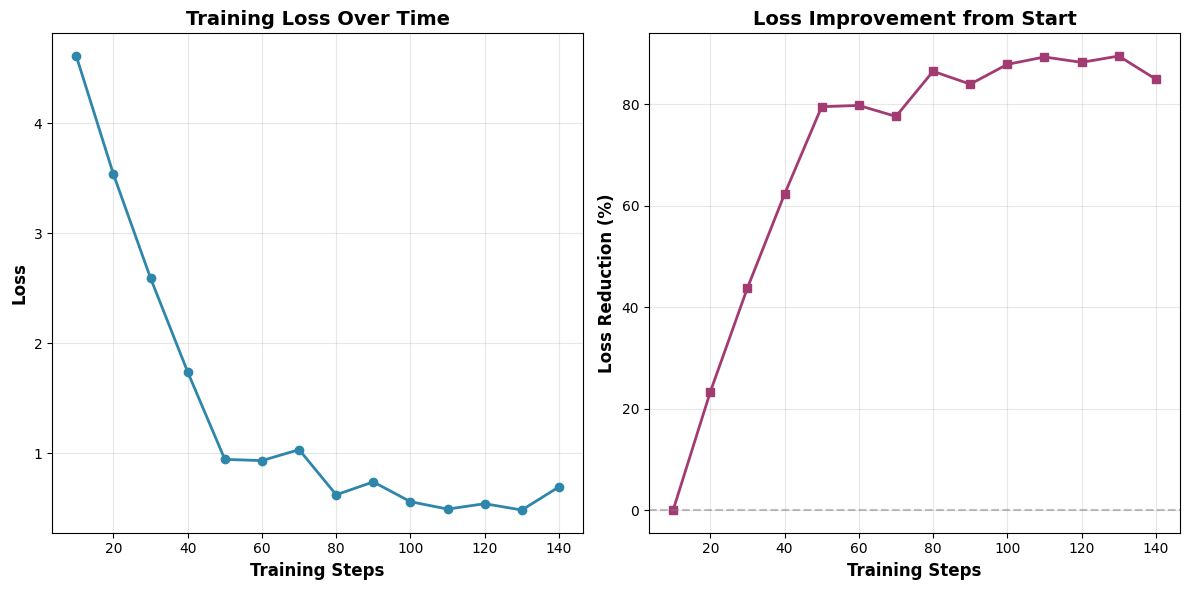


TRAINING PERFORMANCE SUMMARY
Initial Loss: 4.6103
Final Loss: 0.6949
Loss Reduction: 3.9154
Improvement: 84.9%
Total Training Steps: 140


In [89]:
import matplotlib.pyplot as plt

# Create figure with better styling
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(training_history['steps'], training_history['loss'], 
         marker='o', linewidth=2, markersize=6, color='#2E86AB')
plt.xlabel('Training Steps', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Plot loss improvement (percentage decrease from first loss)
plt.subplot(1, 2, 2)
if len(training_history['loss']) > 0:
    initial_loss = training_history['loss'][0]
    loss_reduction = [(initial_loss - loss) / initial_loss * 100 
                      for loss in training_history['loss']]
    plt.plot(training_history['steps'], loss_reduction, 
             marker='s', linewidth=2, markersize=6, color='#A23B72')
    plt.xlabel('Training Steps', fontsize=12, fontweight='bold')
    plt.ylabel('Loss Reduction (%)', fontsize=12, fontweight='bold')
    plt.title('Loss Improvement from Start', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('training_performance.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "=" * 50)
print("TRAINING PERFORMANCE SUMMARY")
print("=" * 50)
print(f"Initial Loss: {training_history['loss'][0]:.4f}")
print(f"Final Loss: {training_history['loss'][-1]:.4f}")
print(f"Loss Reduction: {(training_history['loss'][0] - training_history['loss'][-1]):.4f}")
print(f"Improvement: {((training_history['loss'][0] - training_history['loss'][-1]) / training_history['loss'][0] * 100):.1f}%")
print(f"Total Training Steps: {training_history['steps'][-1]}")
print("=" * 50)

# Save the Fine-tuned Model

In [ ]:
# Save the model
model.save_pretrained(FINETUNED_MODEL_DIR)
tokenizer.save_pretrained(FINETUNED_MODEL_DIR)
print(f"Model saved to {FINETUNED_MODEL_DIR}")

# Test the Fine-tuned Model
Compare the original model with the fine-tuned model

In [ ]:
from peft import PeftModel
import torch

def test_models():
    """Test and compare both models"""
    print("=== TESTING ORIGINAL vs FINE-TUNED MODEL ===")
    print()
    
    # Load tokenizer and models
    test_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    original_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
    
    if os.path.exists(FINETUNED_MODEL_DIR):
        base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
        finetuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL_DIR)
        finetuned_model.eval()
    else:
        print("Fine-tuned model not found!")
        return
    
    # Test questions
    test_questions = [
        "When did Ghana gain independence?",
        "What is the capital of Ghana?",
        "Where is Ghana located?",
        "Who colonized Ghana?",
        "What was Ghana formerly called?"
    ]
    
    correct_original = 0
    correct_finetuned = 0
    
    for question in test_questions:
        print(f"\nQuestion: {question}")
        
        # Test original model
        inputs = test_tokenizer(question, return_tensors="pt")
        with torch.no_grad():
            outputs_orig = original_model.generate(**inputs, max_length=50)
            original_answer = test_tokenizer.decode(outputs_orig[0], skip_special_tokens=True)
        
        # Test fine-tuned model
        with torch.no_grad():
            outputs_ft = finetuned_model.generate(**inputs, max_length=50)
            finetuned_answer = test_tokenizer.decode(outputs_ft[0], skip_special_tokens=True)
        
        print(f"  Original Model: {original_answer}")
        print(f"  Fine-tuned Model: {finetuned_answer}")
        
        # Check correctness (simple string matching)
        expected_answers = {
            "When did Ghana gain independence?": ["1957", "March 6"],
            "What is the capital of Ghana?": ["Accra"],
            "Where is Ghana located?": ["West Africa", "Africa"],
            "Who colonized Ghana?": ["Britain", "British"],
            "What was Ghana formerly called?": ["Gold Coast"]
        }
        
        expected = expected_answers.get(question, [])
        if any(exp.lower() in original_answer.lower() for exp in expected):
            correct_original += 1
        if any(exp.lower() in finetuned_answer.lower() for exp in expected):
            correct_finetuned += 1
    
    print("\n" + "=" * 50)
    print(f"Original Model Accuracy: {correct_original}/{len(test_questions)} = {correct_original/len(test_questions)*100:.1f}%")
    print(f"Fine-tuned Model Accuracy: {correct_finetuned}/{len(test_questions)} = {correct_finetuned/len(test_questions)*100:.1f}%")
    print("=" * 50)

# Run the test
test_models()